# Лабораторная работа по курсу ППП
*Задача о поиске места для офиса* \
Анашкина А.А.

# Постановка задачи

Имеется фирма, еоторая занимается ремонтом оборудования. Клиенты этой фирмы располагаются в разных частях г.Москвы, и, возможно, в других городах России. Каждое взаимодействие фирмы с клиентом заключается в выезде бригады на адрес клиента, что приводит к затратам фирмы, пропорциональным расстоянию от офиса этой фирмы до местоположения клиента. В один прекрасный день Вы, как потенциальный директор фирмы, решаете поменять положение Вашего офиса с целью минимизации издержек. При этом предполагается, что стоимость аренды офиса, его содержания и т.п. почти постоянна, а издержкисвязаны исключительно с необходимостью выезжать к клиентам. \
В качестве исходных данных необходимо использовать некоторый текстовый файл с координатами клиентов (для каждого клиента в отдельной строке указаны широта и долгота его положения, через запятую). Широта и долгота задаются как вещественные числа, в градусах, символ-разделитель - "точка". \
Основная задача состоит в разработке алгоритма поиска оптимального положения офиса. При этом необходимо рассмотреть несколько разных постановок задачи:
1) Все клиенты равнозначны и могут затребовать услуги фирмы с одинаковой вероятностью. Можно считать, что Земмля является "плоской", так как расстояния между разными клиентами невелики. В качестве расстояния от офиса до клиента можно использовать расстояние по прямой.
2) Все клиенты равнозначны и могут затребовать услуги фирмы с одинаковой вероятностью. Поскольку расстояния до клиентов большие, то при рассчётах необходимо учитывать эллиптическую модель Земли. В качестве расстояния от офиса до клиента необходимо учитвыть длину кратчайшего пути по поверхности эллипсоида.
3) Клиенты неравнозначны и могут затребовать услуги фирмы с разными вероятностями. В файле с информацией о клиентах для каждой строки кроме широты и долготы указывается приоритет - некоторое положительное число (чем больше число, тем чаще этому клиенту требуются услуги Вашей фирмы). Как и в первом пункте, можно считать, что Земля "плоская". В качестве расстояние от офиса до клиента можно использовать расстояние по прямой.

Для каждого варианта задачи необходимо придумать постановку соответствующей математической задачи оптимизации и алгоритм численного решения этой задачи. Результатом выполнения работы является программа и краткий отчёт. Программа должна выдавать оптимальные координаты положения офиса.



In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Задача 1

Обозначим предполагаемые координаты точки нахождения офиса за $\overline x = (x, y)$, а координаты точки спроса за $\overline x_j = (x_j, y_j)$. По условию затраты фирмф пропорциональны расстоянию от офиса до клиента, тогда задачу минимизации издержек можно сформулировать в следующем виде:
$$\sum_{j = 1}^n \vert \vert \overline x - \overline x_j \vert \vert \rightarrow \min_{\overline x}.$$
Данная задача размещения производства также носит название задачи Вебера. Она обобщает задачу нахождения геометрической медианы трёх точек, точное геометрическое решение которой предлагали многие известные математики. Однако, если число точек больше трёх, решить задачу Вебера геометрически невозможно. В представленном случае используются итеративные оптимизационные методы. Кун и Куэн предложили алгоритм, основанный на итерационном взвешенном методе наименьших квадратов, изложим его далее.

В качестве начального приближения $\overline x^0$ возьмём среднее всех точек. В нашеё задаче все клиенты равнозначны, тогда на каждом шаге алгоритм приближается к оптимальному решению путём выбора $\overline x^{j+1}$, минимизирующего сумму расстояний:
$$\sum_{i=1}^n \frac{1}{\vert \vert \overline x_i - \overline x^j\vert \vert} \vert \vert \overline x_i - \overline x \vert \vert.$$
Каждая следующая аппроксимация может быть получена из выражения:
$$\overline x^{j+1} = \dfrac{\sum_{i=1}^n \frac{\overline x_i}{\vert \vert \overline x_i - \overline x^j \vert \vert}}{\sum_{i=1}^n \frac{1}{\vert \vert \overline x_i - \overline x^j \vert \vert}}.$$

In [23]:
def task_1(clients, tol, max_n):
# clients - массив (n, 2)
    n = clients.shape[1]
    location = []
    func_val = []
    prev_loc = np.mean(clients, axis=0)
    location.append(prev_loc)
    distance = np.linalg.norm(clients - prev_loc, axis=1)
    func_val.append(np.sum(distance))
    for i in range(1,max_n):
        distance = np.linalg.norm(clients - prev_loc, axis=1)
        cur_loc = np.sum(clients / distance[:, np.newaxis], axis=0) / np.sum(1 / distance)
        new_distance = np.linalg.norm(clients - cur_loc, axis=1)
        func_val.append(np.sum(new_distance))
        location.append(cur_loc)
        if np.linalg.norm(func_val[i-1] - func_val[i]) < tol:
            break
        prev_loc = cur_loc
    print(f'Координаты офиса: {location[-1][0]}, {location[-1][1]}')
    print(f'Значение функционала: {func_val[-1]}')
    return location, func_val

In [24]:
def load_data(file_path):
    data = np.loadtxt(file_path, delimiter=',')
    return data

In [25]:
def generate_data(file_path, num_lines, low, hight):
    with open(file_path, 'w') as file:
        for _ in range(num_lines):
            num1 = np.random.uniform(low, hight)
            num2 = np.random.uniform(low, hight)
            file.write(f"{num1}, {num2}\n")

*визуализация*

In [43]:
def Func_plot(Func_val, axis = np.array([0, 1]), color = 'b'):
    plt.figure(figsize=(6,6))
    plt.plot(Func_val, c = color)
    plt.xlim([0, len(Func_val)])
    plt.ylabel("Значение минимизируемого функционала") # для наименования по нужным осям
    plt.xlabel("Номер итерации")
    plt.title("История значения функционала")
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.axis('equal')
    #plt.savefig('z1_func.eps', format='eps')

In [80]:
def map_plot(clients, location):
    plt.figure(figsize=(6,6))
    plt.scatter(clients[:, 0], clients[:, 1], color='green', marker='o', label='Клиенты')
    plt.scatter(location[-1][0], location[-1][1], color='red', marker='o', label='Офис')
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.title("Расположение офиса и клиентов")
    plt.show()
    

Рассмотрим пример

Координаты офиса: 2.000742021031452, 1.6877066317403757
Значение функционала: 150.54511925609958


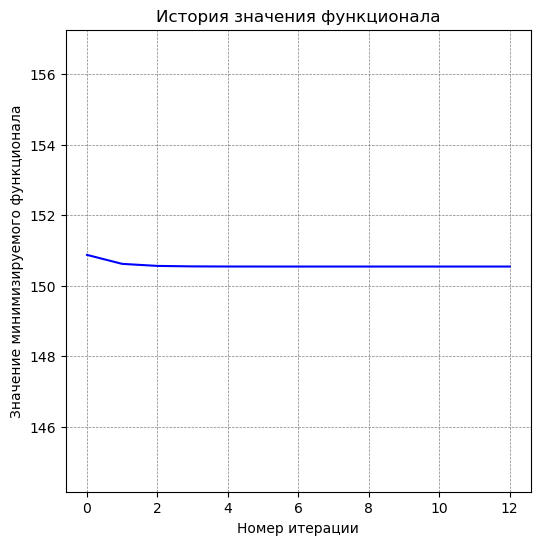

In [91]:
file_name = 'data1.txt'
tol = 1e-7
max_n = 1000
generate_data(file_name, 100, 0, 4)
clients = load_data(file_name)
location, Func_val = task_1(clients, tol, max_n)
Func_plot(Func_val)
plt.savefig('z1_func.eps', format='eps')
#map_plot(clients, location)
#plt.savefig('z1_config.eps', format='eps')

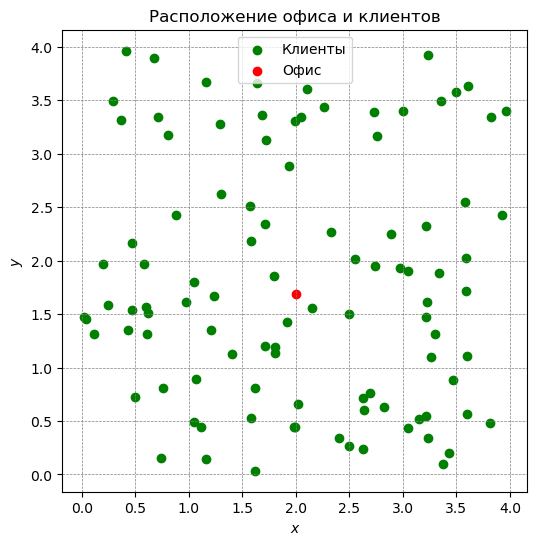

<Figure size 640x480 with 0 Axes>

In [92]:
map_plot(clients, location)
plt.savefig('z1_config.eps', format='eps')

# Задача 2

Эта задача отличается от предыдущей лишь тем, что расстояние рассчитывается по поверхности эллипсоида. Итеративный метод, указанный ранее будет применим к нашей задаче. Воспользуемся библиотекой geopy, которая предоставляет возможность вычисления расстояния по поверхности эллипсоида Земли.

In [8]:
!pip3 install geopy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Настя\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [40]:
from geopy.distance import geodesic

In [48]:
def task_2(clients, tol, max_n):
# clients - массив (n, 2)
    location = []
    func_val = []
    prev_loc = np.mean(clients, axis=0)
    location.append(prev_loc)
    distance = []
    for point in clients:
        distance.append(geodesic(point, prev_loc).kilometers)
    distance = np.array(distance)
    func_val.append(np.sum(distance))
    for i in range(1, max_n):
        #distance = []
        #for point in clients:
        #    distance.append(geodesic(point, prev_loc).kilometers)
        #distance = np.array(distance)
        cur_loc = np.sum(clients / distance[:, np.newaxis], axis=0) / np.sum(1 / distance)
        new_distance = []
        for point in clients:
            new_distance.append(geodesic(point, cur_loc).kilometers)
        new_distance = np.array(new_distance)
        func_val.append(np.sum(new_distance))
        location.append(cur_loc)
        if np.linalg.norm(func_val[i - 1] - func_val[i]) < tol:
            break
        prev_loc = cur_loc
        distance = new_distance
    print(f'Координаты офиса: {location[-1][0]}, {location[-1][1]}')
    print(f'Значение функционала: {func_val[-1]}')
    return location, func_val

In [49]:
def generate_data2(file_path, num_lines):
    with open(file_path, 'w') as file:
        for _ in range(num_lines):
            num1 = np.random.uniform(-90, 90)
            num2 = np.random.uniform(0, 360)
            file.write(f"{num1}, {num2}\n")

*визуализация*

In [50]:
def draw_ellipsoid(a, b, c):
    phi = np.linspace(0, 2 * np.pi, 100)
    psi = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(phi), np.sin(psi))
    y = b * np.outer(np.sin(phi), np.sin(psi))
    z = c * np.outer(np.ones(np.size(phi)), np.cos(psi))
    return x, y, z

In [51]:
def Earth_plot(clients, location):
    a = 6378.1  # экваториальный радиус в километрах
    b = 6378.1  # экваториальный радиус в километрах
    c = 6356.8  # полярный радиус в километрах
    x_points = [a * np.cos(np.radians(lat)) * np.cos(np.radians(lon)) for lat, lon in clients]
    y_points = [b * np.cos(np.radians(lat)) * np.sin(np.radians(lon)) for lat, lon in clients]
    z_points = [c * np.sin(np.radians(lat)) for lat, lon in clients]
    x_office = a * np.cos(np.radians(location[-1][0])) * np.cos(np.radians(location[-1][1]))
    y_office = b * np.cos(np.radians(location[-1][0])) * np.sin(np.radians(location[-1][1]))
    z_office = c * np.sin(np.radians(location[-1][0]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(*draw_ellipsoid(a, b, c), color='lightblue', alpha=0.5)
    ax.scatter(x_points, y_points, z_points, color='green', s=70)
    ax.scatter(x_office, y_office, z_office, color='red', s=100)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")
    plt.show()

Координаты офиса: 5.909154174463327, 166.14441019422617
Значение функционала: 979885.687676593


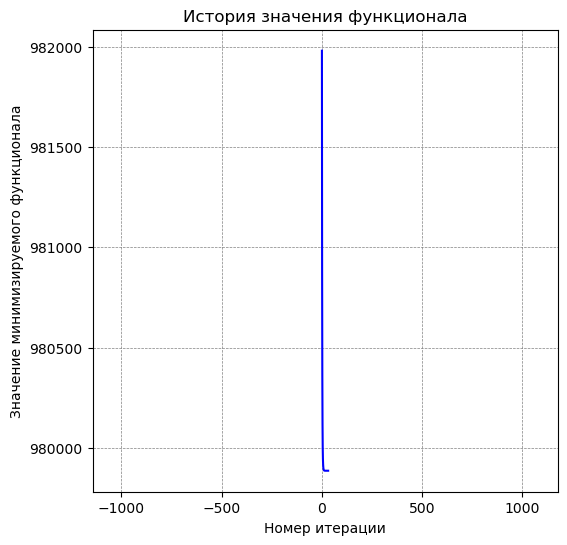

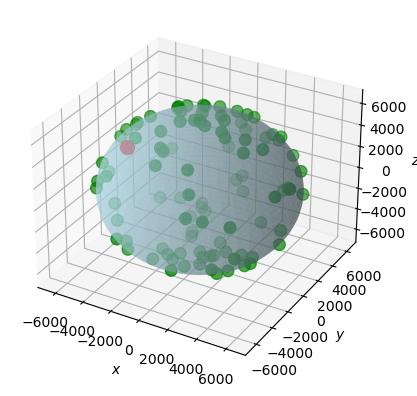

<Figure size 640x480 with 0 Axes>

In [55]:
file_name = 'data2.txt'
tol = 1e-5
max_n = 1000
generate_data2(file_name, 100)
clients = load_data(file_name)
location, Func_val = task_2(clients, tol, max_n)
Func_plot(Func_val)
plt.savefig('z2_func.eps', format='eps')
Earth_plot(clients, location)
plt.savefig('z2_config.eps', format='eps')

# Задача 3

Эта задача отличается от первой наличием весов у каждого клиента. По условию каждому клиенту соответствует число, причём чем больше это число, тем чаще этому клиенту требуются услуги фирмы. Поэтому для каждого клиента можем генерировать вероятность того, что ему понадобятся наши услуги. Тогда веса вычисляются до следующей формуле:
$$w_j = \dfrac{p_j}{\sum_{i=1}^n p_i}.$$
Тогда задача минимизации издержек может быть переформулирована:
$$\sum_{j = 1}^n w_j \vert \vert \overline x - \overline x_j \vert \vert \rightarrow \min_{\overline x}.$$
Каждая следующая аппроксимация может быть получена из выражения:
$$\overline x^{j+1} = \dfrac{\sum_{i=1}^n \frac{w_i \overline x_i}{\vert \vert \overline x_i - \overline x^j \vert \vert}}{\sum_{i=1}^n \frac{w_i}{\vert \vert \overline x_i - \overline x^j \vert \vert}}.$$

In [16]:
def data_separation(data):
    p = data[:, 2]
    weights = p / np.sum(p) 
    clients = np.delete(data, 2, axis=1)
    return weights, clients

In [61]:
def task_3(data, tol, max_n):
# clients - массив (n, 2)
    weights, clients = data_separation(data)
    location = []
    func_val = []
    dists = []
    prev_loc = np.mean(clients, axis=0)
    location.append(prev_loc)
    distance = np.linalg.norm(clients - prev_loc, axis=1)
    func_val.append(np.dot(weights, distance))
    for i in range(1, max_n):
        w = np.array(weights / np.sum(weights / distance)).reshape(100, -1)
        cur_loc = np.sum(w * clients, axis=0)
        new_distance = np.linalg.norm(clients - cur_loc, axis=1)
        func_val.append(np.dot(weights, new_distance))
        location.append(cur_loc)
        if np.linalg.norm(func_val[i - 1] - func_val[i]) < tol:
            break
        prev_loc = cur_loc
        distance = new_distance
    print(f'Координаты офиса: {location[-1][0]}, {location[-1][1]}')
    print(f'Значение функционала: {func_val[-1]}')
    return location, func_val, weights, clients

In [57]:
def generate_data3(file_path, num_lines, loc=0, scale=1):
    with open(file_path, 'w') as file:
        num12 = np.random.normal(loc, scale, (num_lines, 2))
        num3 = np.random.uniform(0, 1, (num_lines, 1))
        for i in range(num_lines):
            file.write(f"{num12[i, 0]}, {num12[i, 1]}, {float(num3[i])}\n")

*визуализация*

In [63]:
        
def func3d(clients, weights, func_val, location):
    x = np.linspace(min(clients.T[0]), max(clients.T[0]), 100)
    y = np.linspace(min(clients.T[1]), max(clients.T[1]), 100)
    X, Y = np.meshgrid(x, y)
    fig3, ax = plt.subplots(subplot_kw={"projection": "3d"})
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            distance = np.linalg.norm(clients - [X[i][j], Y[i][j]], axis=1)
            Z[i][j] = np.dot(weights, distance)
    ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, color='blue', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('$\\mathcal{J}(x,y)$')
    ax.scatter(np.array(location).T[0], np.array(location).T[1], func_val, c='r', alpha=0.6)
    print(np.array(location).T[0])
    print(np.array(location).T[1])
    ax.view_init(15, 20)
    ax.set_title('Значения функционала')
    plt.show()

In [21]:
def map_plot_weights(clients, weights, location):
    plt.figure(figsize=(6,6))
    plt.scatter(clients[:, 0], clients[:, 1], c=weights, cmap='Blues', marker='o', label='Клиенты')
    plt.colorbar(label="Важность клиента")
    plt.scatter(location[-1][0], location[-1][1], color='red', marker='o', label='Офис')
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.title("Расположение офиса и клиентов")
    plt.show()

Координаты офиса: -0.08573011638516292, 0.21725910327983097
Значение функционала: 1.3324814197494752


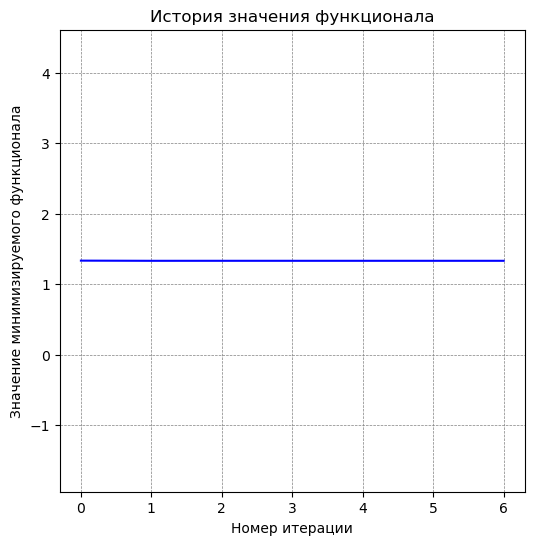

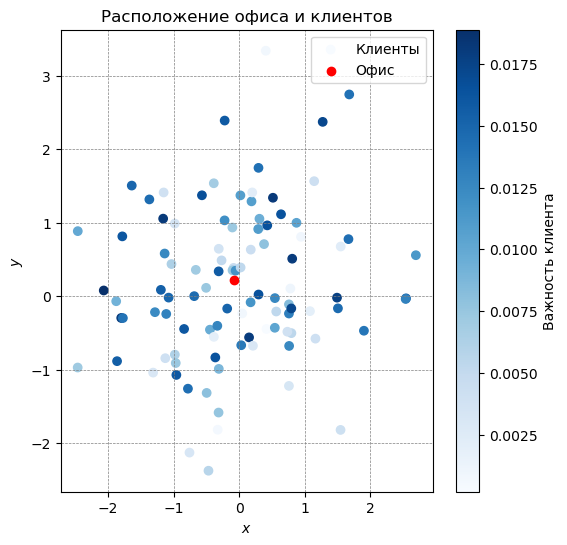

[-0.05248508 -0.08984945 -0.08470163 -0.08597487 -0.08567585 -0.08574699
 -0.08573012]
[0.15734055 0.2276984  0.2146527  0.21787935 0.21712158 0.21730187
 0.2172591 ]


<Figure size 640x480 with 0 Axes>

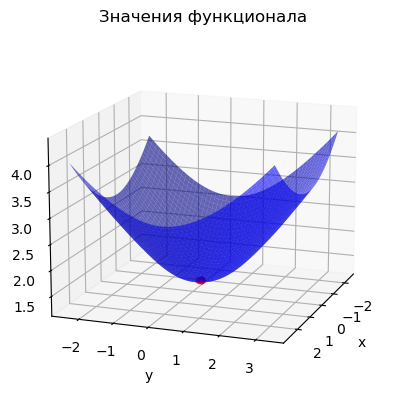

In [72]:
file_name = 'data3.txt'
tol = 1e-6
max_n = 1000
generate_data3(file_name, 100, 0, 1)
data = load_data(file_name)
location, Func_val, weights, clients = task_3(data, tol, max_n)
weight = weights.reshape(100, 1)
Func_plot(Func_val)
plt.savefig('z3_func.eps', format='eps')
map_plot_weights(clients, weights, location)
plt.savefig('z3_config.eps', format='eps')
func3d(clients, weights, Func_val, location)
